Number of rows: 101766
Number of columns: 50
Random Forest Brier Score: 0.0961
XGBoost Brier Score: 0.0941
Logistic Regression Brier Score: 0.0960


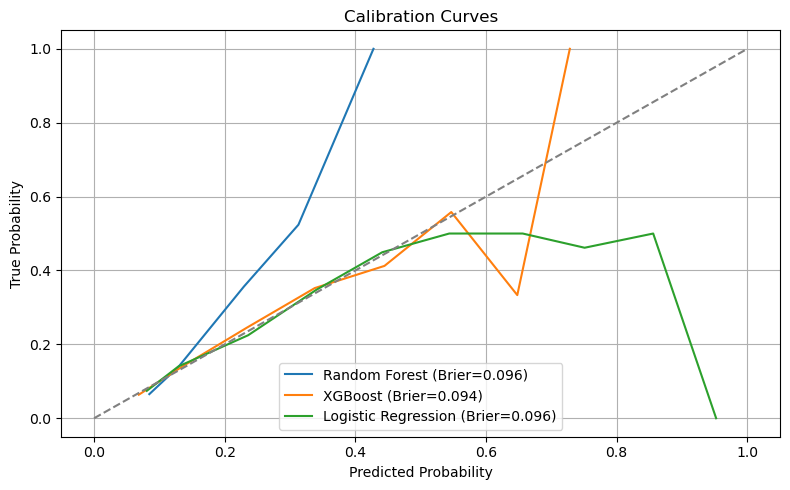

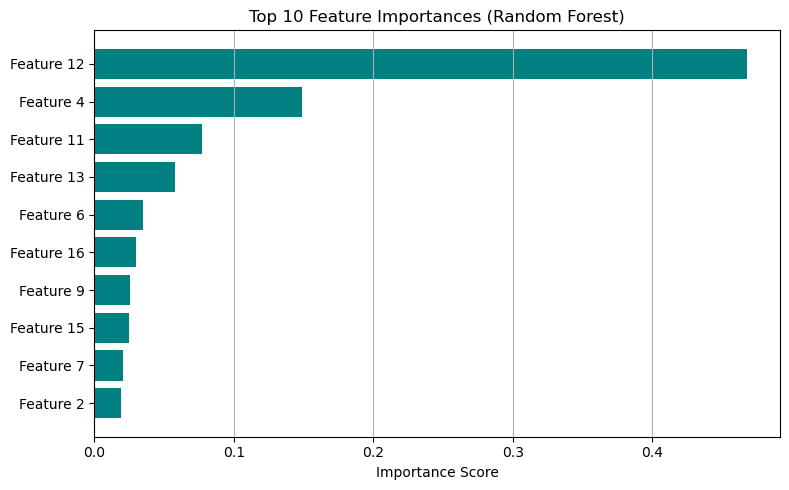

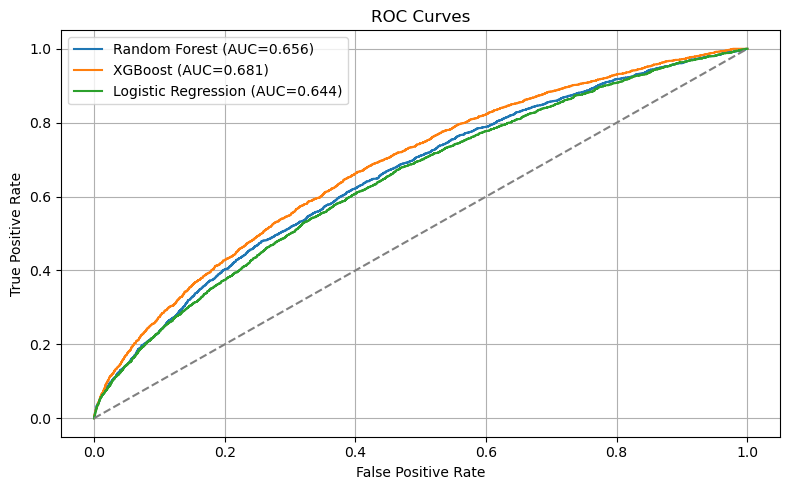

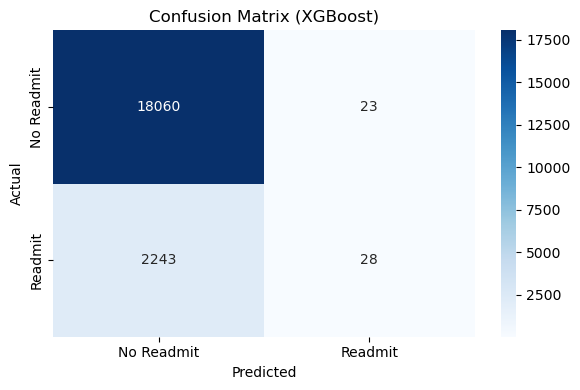

Clinical Utility Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.55      0.01      0.02      2271

    accuracy                           0.89     20354
   macro avg       0.72      0.51      0.48     20354
weighted avg       0.85      0.89      0.84     20354



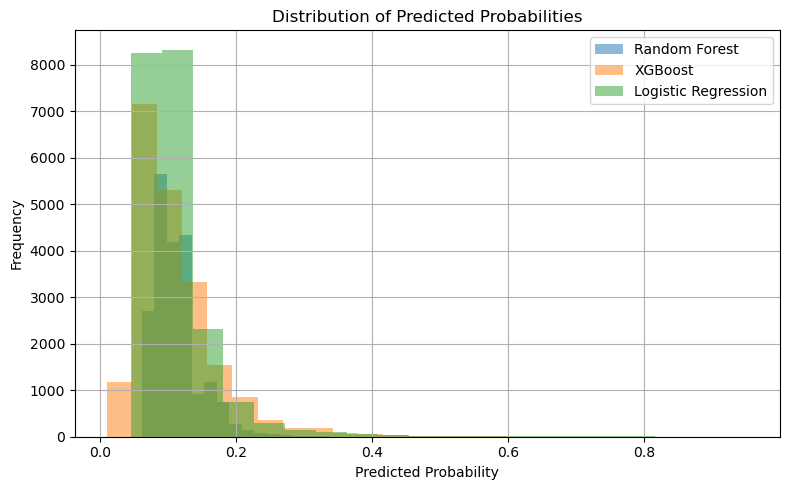

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold

# Load and preprocess dataset
df = pd.read_csv("diabetic_data.csv")
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])

df.drop(['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], axis=1, inplace=True)
df.replace('?', pd.NA, inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])

# Impute missing values
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Binary target: readmitted within 30 days
df_imputed['readmitted'] = df_imputed['readmitted'].apply(lambda x: 1 if x == le.transform(['<30'])[0] else 0)

# Feature selection
X = df_imputed.drop('readmitted', axis=1)
y = df_imputed['readmitted']
X_selected = VarianceThreshold(threshold=0.01).fit_transform(X)

# Scale and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train models
rf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
xgb = XGBClassifier(n_estimators=50, max_depth=3, eval_metric='logloss', random_state=42)
lr = LogisticRegression(max_iter=500)

models = {'Random Forest': rf, 'XGBoost': xgb, 'Logistic Regression': lr}
for name, model in models.items():
    model.fit(X_train, y_train)

# Calibration curves and Brier scores
plt.figure(figsize=(8, 5))
for name, model in models.items():
    prob_pos = model.predict_proba(X_test)[:, 1]
    brier = brier_score_loss(y_test, prob_pos)
    print(f"{name} Brier Score: {brier:.4f}")
    prob_true, prob_pred = calibration_curve(y_test, prob_pos, n_bins=10)
    plt.plot(prob_pred, prob_true, label=f"{name} (Brier={brier:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curves")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Feature importance plot (Random Forest)
importances = rf.feature_importances_
top_indices = np.argsort(importances)[::-1][:10]
top_features = [f"Feature {i}" for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(8, 5))
plt.barh(top_features[::-1], top_importances[::-1], color='teal')
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# ROC curves
plt.figure(figsize=(8, 5))
for name, model in models.items():
    prob_pos = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, prob_pos)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion matrix heatmap (XGBoost)
threshold = 0.5
preds = (xgb.predict_proba(X_test)[:, 1] > threshold).astype(int)
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()

# Classification report
print("Clinical Utility Report:")
print(classification_report(y_test, preds))

# Predicted probability histogram
plt.figure(figsize=(8, 5))
for name, model in models.items():
    prob_pos = model.predict_proba(X_test)[:, 1]
    plt.hist(prob_pos, bins=20, alpha=0.5, label=name)

plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()